# Surrogate Outcomes

In [1]:
from y0.dsl import D, W, X, Y, Z, Sum, Product, P, Variable, Pi1, Pi2
from y0.graph import NxMixedGraph
from y0.algorithm.identify import identify_outcomes
from y0.algorithm.transport import identify_target_outcomes
from matplotlib_inline.backend_inline import set_matplotlib_formats

set_matplotlib_formats("svg")

## Cancer

The first scenario we will explore is about the relationship between smoking ($S$), accumulation of tar in the lungs ($T$), and cancer ($C$). 

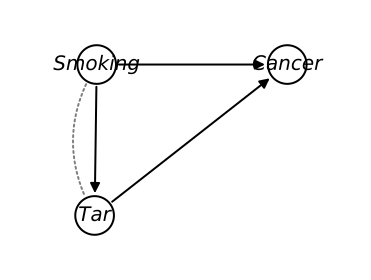

In [2]:
Smoking, Tar, Cancer = (Variable(n) for n in ("Smoking", "Tar", "Cancer"))

graph = NxMixedGraph.from_edges(
    directed=[(Smoking, Tar), (Tar, Cancer), (Smoking, Cancer)], undirected=[(Smoking, Tar)]
)
graph.draw()

Suppose Pall Mall has a new cigarette that has no tar in it!  They conduct a clinical trial $\pi_1$ where they randomly assign some volunteers to smoke their new cigarette, and the other volunteers receive regular cigarettes. As an outcome, they measure tar buildup in the lungs, but unfortunately, the trial is stopped before any of the volunteers get cancer. This trial does not have enough information to estimate the causal effect of smoking on cancer $P^{\pi_1}(Cancer | \text{do}(Smoking))$ from the measurements of $P^{\pi_1}(Tar | \text{do}(Smoking)$.

In [3]:
identify_outcomes(graph, treatments={Smoking}, outcomes={Cancer}) is None

True

 At the same time, we have observational data over many years that show the correlation of smoking on cancer, but we don't know who chose the Pall Mall "no tar" cigarettes vs the tar-filled cigarettes.  This observational data does not have enough information to estimate $P^{\pi^\ast}(Cancer | \text{do}(Smoking)$ from the measurements of $P^{\pi^\ast}(Smoking, Cancer, Tar)$.

Neither dataset is sufficient to estimate the causal effect of smoking on cancer, but perhaps by combining the two, we can identify the query.
 

In [4]:
identify_target_outcomes(
    graph=graph,
    target_outcomes={Cancer},
    target_interventions={Smoking},
    surrogate_outcomes={Pi1: {Tar}},
    surrogate_interventions={Pi1: {Smoking}},
)

Sum[Tar](PP[π1][Smoking](Tar) * ((P(Cancer, Smoking, Tar) / P(Smoking, Tar))))

We can interpret this result as taking the observational data ($\pi^\ast$) such that the conditional $P(Cancer| Smoking, Tar)$ is stratified by Tar, and reweighting the percentage of people who have tar in their lungs by the percentage of people who had tar in their lungs in the clinical trial ($\pi_1$).  The summation over Tar means that the final estimate will only have Smoking and Cancer in it.  If you didn't do the reweighting, you would only recover the probability of cancer given smoking.

Note that the surrogate outcomes algorithm implicitly assumes that observational data from the target population is always available.

## Relation between going to Class and Getting a Job

Suppose we want to find out if going to class during college has an effect on getting a job after graduation. We have the observational data that shows relationships between going to class, test scores, gpa, and jobs after graduation but the observational data is not enough to estimate $P^{\pi^\ast}(Job | \text{do}(Class)$ $P^{\pi^\ast}(Class, TestScores, GPA, Job)$

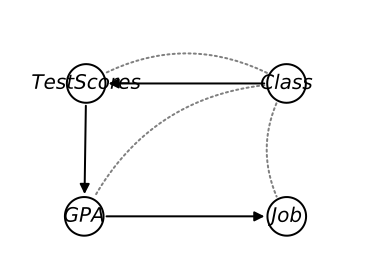

In [5]:
Class, TestScores, GPA, Job = (
    Variable("Class"),
    Variable("TestScores"),
    Variable("GPA"),
    Variable("Job"),
)

graph = NxMixedGraph.from_edges(
    directed=[(Class, TestScores), (TestScores, GPA), (GPA, Job)],
    undirected=[(TestScores, Class), (Job, Class)],
)
graph.draw()

Assume that an experiment tested how students performed on tests by assigning some students to attend class, while other to not attend, this gives us $P^{\pi_2}(TestScores | \text{do}(Class)$.  Another experiment was performed to test the relationship between getting a job and GPA where similar students with randomized GPA applied for jobs giving $P^{\pi_2}(Job | \text{do}(GPA)$. 

In [6]:
identify_outcomes(graph, treatments={Class}, outcomes={Job}) is None

True

In [7]:
item = identify_target_outcomes(
    graph=graph,
    target_outcomes={Job},
    target_interventions={Class},
    surrogate_outcomes={Pi1: {TestScores}, Pi2: {Job}},
    surrogate_interventions={Pi1: {Class}, Pi2: {GPA}},
)
print(item)

None
